<a href="https://colab.research.google.com/github/Mariannly/Quark5-CoAfina2025/blob/main/Modelo_predictivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔮 Modelo Predictivo de Sequías — S-ARIDA


**Autores**: Mariannly Marquez, Alexa Serrano, Cristian Orduz, Jhon Almanzar y Andre Avila (Equipo Quark5).  
**Afiliación**: Universidad Industrial de Santander (UIS) y Universidad Yachay Tech  
**Objetivo**: Predecir de manera probabilística el **riesgo de sequía mensual**, expresado como una **probabilidad (%)**, y clasificarlo en categorías de riesgo útiles para la **alerta temprana** y la **gestión ambiental**.


In [ ]:
# Instalar modulos necesarios
!pip install -q "cdsapi>=0.7.7" #API ERA5
!pip install -q xarray
!pip install -q cfgrib
!pip install -q --upgrade "xclim>=0.46" #Modulo de estadisticas climáticas
!pip install -q pymannkendall # Analisis estadistico

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.0/379.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
# Importar modulos necesarios
import os
import cdsapi
import time
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import xclim as xc
import pymannkendall as mk
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight
import joblib

## 📦 1. Obtención de los Datos

**Fuente:**

- ERA5-Land monthly averaged data (Copernicus Climate Data Store)
Variables empleadas:
  - Precipitación total (tp)
  - Temperatura del aire a 2 m (t2m)
  - Evaporación total (e)
  - Evaporación parcial (pev)
  - Humedad del suelo (swvl1, swvl2, swvl3, swvl4)

**Periodo temporal**: 1985 – 2025  
**Área de estudio**: Riohacha, Colombia.

In [ ]:
# Acceder a ERA5 con la API
cdsapirc_content = """url: https://cds.climate.copernicus.eu/api
key: 01876cbb-e8a2-4cb4-8d98-5f4ba769fc1a
"""

# Crear el archivo de configuración en la ruta esperada
with open(os.path.expanduser("~/.cdsapirc"), "w") as f:
    f.write(cdsapirc_content)

In [ ]:
# 1985-2024
c = cdsapi.Client()

# Definir detalles de descarga
dataset = "reanalysis-era5-land-monthly-means"
bbox_riohacha = {
    "north": 11.80,
    "south": 11.30,
    "west": -73.20,
    "east": -72.60,
}
request_1985_2024 = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": [
        "total_precipitation",
        "2m_temperature",
        "volumetric_soil_water_layer_1",
        "volumetric_soil_water_layer_2",
        "volumetric_soil_water_layer_3",
        "volumetric_soil_water_layer_4",
        "surface_solar_radiation_downwards",
        "potential_evaporation",
        "total_evaporation"
    ],
    "year": [str(y) for y in range(1985, 2025)],   # 1985–2024
    "month": [f"{m:02d}" for m in range(1, 13)],
    "time": "00:00",
    "area": [
        bbox_riohacha["north"],
        bbox_riohacha["west"],
        bbox_riohacha["south"],
        bbox_riohacha["east"],
    ],
    "format": "netcdf",
}

# Descargar y guardar
data_file = c.retrieve(dataset, request_1985_2024).download()

2025-11-09 03:49:01,164 INFO Request ID is 25e313b9-3d68-48e0-89b5-d082ca95260a
INFO:ecmwf.datastores.legacy_client:Request ID is 25e313b9-3d68-48e0-89b5-d082ca95260a
2025-11-09 03:49:01,312 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-11-09 03:49:15,262 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


befff589feaa9f29fbadef8d7540c4cb.zip:   0%|          | 0.00/417k [00:00<?, ?B/s]

In [ ]:
# 2025
# Acceder al cliente
y = cdsapi.Client()

request_2025 = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": [
        "total_precipitation",
        "2m_temperature",
        "volumetric_soil_water_layer_1",
        "volumetric_soil_water_layer_2",
        "volumetric_soil_water_layer_3",
        "volumetric_soil_water_layer_4",
        "surface_solar_radiation_downwards",
        "potential_evaporation",
        "total_evaporation"
    ],
    "year": ["2025"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10"
    ],
    "time": "00:00",
    "area": [
        bbox_riohacha["north"],
        bbox_riohacha["west"],
        bbox_riohacha["south"],
        bbox_riohacha["east"],
    ],
    "format": "netcdf",
}

# Descargar y guardar
data_file_2025 = y.retrieve(dataset, request_2025).download()

2025-11-09 03:49:18,123 INFO Request ID is 106047f8-7535-46ee-bd33-49b2969c4824
INFO:ecmwf.datastores.legacy_client:Request ID is 106047f8-7535-46ee-bd33-49b2969c4824
2025-11-09 03:49:18,405 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-11-09 03:49:32,473 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-11-09 03:49:40,218 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-11-09 03:49:51,753 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


85ebbb2c55f67dcaa2e59a44cca8d6a.zip:   0%|          | 0.00/102k [00:00<?, ?B/s]

In [ ]:
def era5_to_monthly_df(ds):
    """Convierte ERA5-Land a DataFrame mensual promedio."""
    # Pasar a DataFrame y limpiar
    df = ds.to_dataframe().dropna().reset_index()
    df = df.drop(["number", "expver"], axis=1, errors="ignore")
    df["valid_time"] = pd.to_datetime(df["valid_time"])

    # Columnas a promediar
    value_cols = ["t2m","swvl1","swvl2","swvl3","swvl4","ssrd","pev","e","tp"]

    # Promedio por mes
    df_monthly = (
        df.groupby("valid_time", as_index=False)[value_cols]
          .mean()
    )

    return df_monthly

In [ ]:
# Descomprimir archivo
!unzip -q {data_file}
file = "data_stream-moda.nc"

# Leer y ver archivo
ds_1985_2024 = xr.open_dataset(file)

In [ ]:
!unzip -q {data_file_2025}
file = "data_stream-moda.nc"

# Leer y ver archivo
ds_2025 = xr.open_dataset(file)

replace data_stream-moda.nc? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
df_2024 = era5_to_monthly_df(ds_1985_2024)
df_2025 = era5_to_monthly_df(ds_2025)

In [ ]:
df = pd.concat([df_2024, df_2025], ignore_index=True)

## ⚙️ 2. Preprocesamiento de Datos

In [ ]:
# Fechas
t = pd.to_datetime(df["valid_time"]).values

# conviertir a mm/día y ajustar valores
pr_rate  = df["tp"].to_numpy() *30 * 1000.0
pet_rate = -df["pev"].to_numpy() *30 * 1000.0

# Empaquetar con unidades
pr  = xr.DataArray(pr_rate,  coords={"time": t}, dims=("time",), attrs={"units": "mm d-1"})
pet = xr.DataArray(pet_rate, coords={"time": t}, dims=("time",), attrs={"units": "mm d-1"})

# Restar y reasignar units
wb = pr - pet
wb = wb.assign_attrs(units="mm d-1")

# Funciones de SPI y SPEI
SPI  = getattr(xc.indices, "spi",  getattr(xc.indices, "standardized_precipitation_index"))
SPEI = getattr(xc.indices, "spei", getattr(xc.indices, "standardized_precipitation_evapotranspiration_index"))

# Calcular y guardar data
windows = [1, 3, 6, 12]
spi  = {k: SPI(pr, window=k).to_series().rename(f"SPI_{k}") for k in windows}
spei = {k: SPEI(wb=wb, window=k).to_series().rename(f"SPEI_{k}") for k in windows}


In [ ]:
# Unir valores de SPI y SPEI
spi_df  = pd.concat(spi.values(), axis=1)
spei_df = pd.concat(spei.values(), axis=1)
indices_df = pd.concat([spi_df, spei_df], axis=1)

# Merge con la df original por fecha
df = df.set_index("valid_time").join(indices_df)
df = df.reset_index()

In [ ]:
days = 30

# Pasar a °C
df["t2m"] = df["t2m"] - 273.15

# m³/m³ (fracción volumétrica, entre 0 y 1)
for col in ["swvl1","swvl2","swvl3","swvl4"]:
    df[col] = df[col] * 100
# mm/mes (acumulado mensual)
df["tp"] = df["tp"] * days * 1000

# mes (acumulado mensual)
df["e"] = -df["e"] * days * 1000

# mes (acumulado mensual)
df["pev"] = -df["pev"] * days * 1000

# MJ/m²/día
df["ssrd"] = df["ssrd"] / 86400.0

In [ ]:
df = df.dropna()

# Descargar el DataFrame como archivo Parquet
df.to_parquet("dataset_clima.parquet")

from google.colab import files
files.download("dataset_clima.parquet")

## ⚙️ 3. Entrenamiento del Modelo IA

In [ ]:
# Df para le modelo
dr = df.copy()

In [ ]:
# Coumnas necesarias y cálculo de SPI3
dr = dr.drop(["SPI_1", "SPI_3", "SPI_6", "SPI_12", "SPEI_1", "SPEI_6", "SPEI_12"], axis=1)

dr["SPEI_next"] = dr["SPEI_3"].shift(-1)

#Ultimo dato para validación
X_future = dr.iloc[-1, :-1].values
X_future_clean = np.array(X_future[1:10], dtype=float).reshape(1, -1)

dr = dr.dropna()

dr = dr.drop("SPEI_3", axis=1)

In [ ]:
X_future_clean

array([[ 26.65386963,  33.1652565 ,  30.63091087,  18.31984138,
         17.82552528, 194.16429138, 169.96853638, 112.61542511,
        276.20211792]])

In [ ]:
# Definir umbral de sequia y clasificación
dr["drought_next"] = (dr["SPEI_next"] <= -0.5).astype(int)

In [ ]:
# Preparar datos
feature_cols = [
    "t2m",
    "swvl1","swvl2","swvl3","swvl4",
    "ssrd",
    "pev",
    "e",
    "tp"
]

X = dr[feature_cols].values
y = dr["drought_next"].values

# Train / Test Split 80/20
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

In [ ]:
# Modelo: HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=9,
    max_iter=800,
    min_samples_leaf=5,
)

# Ajusta de pesos por desvalance de datos
sample_weight = compute_sample_weight(class_weight={0:1.0, 1:6.0}, y=y_train)


# Entrenamiento
clf.fit(X_train, y_train, sample_weight=sample_weight)

HistGradientBoostingClassifier(learning_rate=0.05, max_depth=9, max_iter=800,
                               min_samples_leaf=5)

## ✏️ 3. Validación del Modelo y Predicción

In [ ]:
# Validación
y_pred = clf.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred, digits=3))

[[36 14]
 [11 35]]
              precision    recall  f1-score   support

           0      0.766     0.720     0.742        50
           1      0.714     0.761     0.737        46

    accuracy                          0.740        96
   macro avg      0.740     0.740     0.740        96
weighted avg      0.741     0.740     0.740        96



In [ ]:
# Validación ultima linea
y_prob_future = clf.predict_proba(X_future_clean)[0]

print(y_prob_future)

[9.99250181e-01 7.49818945e-04]


In [ ]:
# Probabilidades de la validación
y_prob = clf.predict_proba(X_val)


# Mapeo
idx_0 = np.where(clf.classes_ == 0)[0][0]
idx_1 = np.where(clf.classes_ == 1)[0][0]

prob_0 = y_prob[:, idx_0]
prob_1 = y_prob[:, idx_1]

In [ ]:
n = len(prob_0)

In [ ]:
# Datos fechas
fechas_val = dr["valid_time"].iloc[-n:].reset_index(drop=True)

# Desplazar todas las fechas +1 mes
fechas_val_plus1 = fechas_val + pd.DateOffset(months=1)

# Construir tabla de resultados usando las fechas desplazadas
val_results = pd.DataFrame({
    "valid_time": fechas_val_plus1,
    "proba": prob_1
})

# Última fecha del dataframe
ultima_fecha = val_results["valid_time"].max()

# Nueva fecha manual (un mes después)
nueva_fecha = ultima_fecha + pd.DateOffset(months=1)

# Agregar nueva fila al final
val_results.loc[len(val_results)] = {
    "valid_time": nueva_fecha,
    "proba": y_prob_future[0],
}

In [ ]:
# Guardar dataset
val_results.to_parquet("dataset_modelo.parquet")

from google.colab import files
files.download("dataset_modelo.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2726656049.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


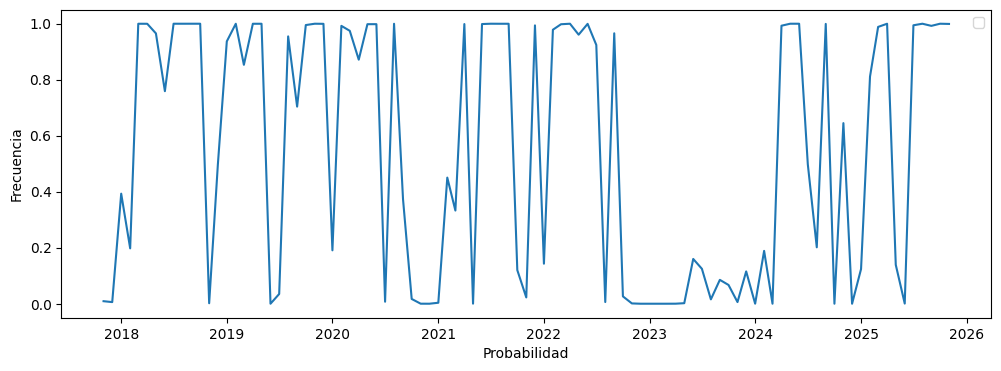

In [ ]:
# Graficar la probabilidad de posible sequía
plt.figure(figsize=(12, 4))
plt.plot(val_results["valid_time"], val_results["proba"], linestyle='-')
plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

In [ ]:
# Guardar modelo
joblib.dump(clf, "modelo_sequia_hgb.pkl")

['modelo_sequia_hgb.pkl']

## 📰 Referencias

[1] Muñoz Sabater, J. (2019): ERA5-Land monthly averaged data from 1950 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.68d2bb30 (Accessed on 08-11-2025)

[2] Caballero Fernández, D., Salvador Franch, F., Padrón Padrón, P. A., & Salvà Catarineu, M. (2025). Uso de datos de reanálisis climático del ERA5 y el SPI para el estudio de las sequías (1941-1970) en El Hierro (Islas Canarias). Investigaciones Geográficas, (84), 89-112. https://doi.org/10.14198/INGEO.29359

[3] Erika Londoño, Daniel Criollo, Luis González (2023). Crisis Humanitaria en la Guajira: Las intervenciones estratégicas del Gobierno. Departamento Nacional de Planeación.

[4] Hererra posada D. Aristizábal E “Artificial Intelligence and Machine Learning Model for Spatial and Temporal
Prediction of Drought Events in the Department of Magdalena, Colombia”. DOI:
http://doi.org/10.17981/ingecuc.18.2.2022.20

[5] Eduardo León, Carlos Acosta (2015). Análisis de Vulnerabilidad del Territorio por Sequía en el Departamento de la Guajira, Colombia, a partir de una visión basada en necesidades básicas insatisfechas.  https://files.core.ac.uk/download/pdf/71895641.pdf

[6] Boletín 1 del Consejo Nacional del Agua 2023. https://www.minambiente.gov.co/boletin-no-1-del-consejo-nacional-del-agua-preparacion-para-la-alta-probabilidad-de-ocurrencia-del-fenomeno-del-nino-2023